<a href="https://colab.research.google.com/github/Flamisell/StewartPlatformLocalSingularityAvoidance_py/blob/main/StewartPlatformSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stweart Platform Simulation with Trapezoidal Velocity Trajectory Planner and Local Singularity Avoidance

This Colab notebook simulates a Stewart Platform with a Trapezoidal Velocity Trajectory Planner and Local Singularity Avoidance, using four key classes:

* The **Robot** class models the Stewart Platform, handling forward/inverse kinematics, actuator forces, and singularity detection.
* The **Trapezoidal Velocity** class manages trajectory planning, generating desired joint trajectories.
* The **Controller** class handles control logic, issuing joint commands and tracking desired trajectories.
* The **Simulation** class ties it all together, running dynamic simulations, visualizing real-time behavior, and analyzing performance.

In [7]:
# @title Needed Libraries
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Stewart Platform Class


This Stewart Platform Class has multiple uses that we will not fully cover here. The main function of the class that will be used here are the *Inverse Kinematics*, *Forward Kinematics* , *Load Singularities*  and *Find Closest singularity*. Inverse and Forward kinematics are used to move from joint space to task space and vice versa when needed. The main focus of this class will be around *Load Singularities* and *Find Closest singularity* functions. The first one is used to upload the singularity positions in task space found offline, the second one is used to find the closest singularity given a pose.

Key functions description:

In the  *__find_closest_singularity_*  function:

1.   Using the workspace boundaries, the pose of the robot and the singularities get normalized.
2.   The euclidean distance between the pose and all the singularities is calculated
3.   The minimum distance is found and the closest singularity is selected.




In [8]:
# @title Sterwart Platform Class
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

class StewartPlatform:

    def __init__(self, r_b , phi_b , r_p, phi_p):
        self.r_b = r_b # radius of base
        self.phi_b = phi_b # angle between base joints
        self.r_p = r_p # radius of platform
        self.phi_p = phi_p # angle between platform joints
        self.options = {
            1: self.getSingularValueIndex,
            2: self.getManipulabilityIndex,
            3: self.getConditionNumber,
            4: self.getLocalConditionIndex,
            5: self.getLDI,
            6: self.getLocalConditionIndexT
        }

    ############################################ IK ##############################################
    def __inverse_kinematics(self, pose): ## Inverse Kinematics (Vectorial Closing Loop)
        if len(pose) != 6:
            raise ValueError("Pose must be a 6-element list or array")

        self.p_i = np.zeros([6, 3])
        self.b_i = np.zeros([6, 3])
        self.l_i = np.zeros([6, 3])
        self.l_i_unit = np.zeros([6, 3])

        self.pose_vect = pose
        x_p, y_p, z_p, roll, pitch, yaw = pose

        self.r = R.from_euler("ZYX", (yaw, pitch, roll), degrees=True)  #rotation matrix
        angles = np.array([0, 120, 120, 240, 240, 0])

        for i in range(6):
            j = -1 if (i % 2) == 1 else 1
            self.b_i[i, 0] = self.r_b * np.cos(np.deg2rad(angles[i] + j * self.phi_b / 2)) # base points
            self.b_i[i, 1] = self.r_b * np.sin(np.deg2rad(angles[i] + j * self.phi_b / 2))
            self.p_i[i, 0] = self.r_p * np.cos(np.deg2rad(angles[i] + j * self.phi_p / 2)) # platform points
            self.p_i[i, 1] = self.r_p * np.sin(np.deg2rad(angles[i] + j * self.phi_p / 2))
            self.l_i[i, :] = np.array([x_p, y_p, z_p]) + self.r.as_matrix().dot(self.p_i[i]) - self.b_i[i] # legs vectors
            self.l_i_unit[i, :] = self.l_i[i, :] / np.linalg.norm(self.l_i[i, :]) # unit legs vectors
            self.p_i[i] = self.l_i[i, :] + self.b_i[i] # moving platform points wrt base frame

        return self.l_i

    def getIK(self, pose):
        return self.__inverse_kinematics(pose)

    ############################################ Jacobian ##############################################
    def __jacobian(self): # Calculate Jacobian q_dot=Jacobian*x_dot
        if not hasattr(self, 'l_i_unit') or not hasattr(self, 'p_i'):
            raise AttributeError("Run inverse kinematics before calculating the Jacobian")
        self.jacobian = np.zeros([6, 6])
        for i in range(6):
            lastcols = np.cross(self.r.as_matrix().dot(self.p_i[i]), self.l_i_unit[i])
            self.jacobian[i, :3] = self.l_i_unit[i]
            self.jacobian[i, 3:] = lastcols

        return self.jacobian

    def getJacobian(self):
        return self.__jacobian()

    ############################################ FK ##############################################
    def __forward_kinematics(self, starting_pose, lengths_desired, plot_flag): # Newton Method Optimization.
        if not isinstance(starting_pose, (list, np.ndarray)) or len(starting_pose) != 6:
            raise ValueError("Starting pose must be a list or numpy array with 6 elements")
        if not isinstance(lengths_desired, (list, np.ndarray)) or len(lengths_desired) != 6:
            raise ValueError("Lengths desired must be a list or numpy array with 6 elements")

        self.pose_vect = starting_pose
        x_p, y_p, z_p, roll, pitch, yaw = starting_pose
        self.r = R.from_euler("ZYX", (yaw, pitch, roll), degrees=True)

        # Newton Method Parameters
        max_count = 100
        epsilon = 0.0001
        alpha_pos = 0.2
        alpha_rot = 0.2
        # variables
        est_pose_vect = np.copy(starting_pose)
        est_pose = np.zeros([4, 4])
        est_pose[:3, :3] = self.r.as_matrix()
        est_pose[:3, 3] = [x_p, y_p, z_p]
        est_pose[3, 3] = 1
        delta_lengths = np.zeros(6)
        delta_T = np.identity(4)
        error = epsilon + 1
        count = 0

        while error > epsilon and count < max_count:
            # find new variables
            legs_est = self.__inverse_kinematics(est_pose_vect)
            lengths_est = np.linalg.norm(legs_est, axis=1)
            delta_lengths = lengths_desired - lengths_est
            J = self.__jacobian()
            J_T = J.transpose()
            # find x_delta with pseudoinverse
            J_star = np.linalg.inv(J_T.dot(J) + 0.0001 * np.identity(6)).dot(J_T)
            x_delta = np.dot(J_star, delta_lengths)
            x_delta_pos = x_delta[:3] * alpha_pos
            x_delta_rot = x_delta[3:] * alpha_rot
            # transform x_delta to delta_T
            r_delta = R.from_euler("ZYX", x_delta_rot)
            delta_T[:3, :3] = r_delta.as_matrix()
            delta_T[:3, 3] = x_delta[:3]
            # move pose
            est_pose = np.dot(delta_T, est_pose)
            # transform est_pose to est_pose_vect
            est_pose_vect[:3] = est_pose[:3, 3]
            self.r_pos = R.from_matrix(est_pose[:3, :3])
            est_pose_vect[3:] = self.r_pos.as_euler("ZYX", degrees=True)
            # find error and update counter
            error = np.linalg.norm(delta_lengths)
            count += 1

            # Uncomment to plot during FK procedure
            if plot_flag:
              self.plot()

        if count < max_count:
            self.pose_vect = est_pose_vect
            # print("Forward Kinematics converged!")
            # print("Estimated pose:", est_pose_vect)
            # print("Desired Lengths:", lengths_desired)
            # print("Estimated Lengths:", lengths_est)
            # print("Error:", error)
            # print("Iterations:", count)
        else:
            print("Forward Kinematics did not converge")
            print("Estimated pose:", est_pose_vect)
            print("Desired Lengths:", lengths_desired)
            print("Estimated Lengths:", lengths_est)
            print("Error:", error)
            print("Iterations:", count)

        return self.pose_vect

    def getFK(self, starting_pose, lengths_desired, plot_flag):
        return self.__forward_kinematics(starting_pose, lengths_desired, plot_flag)

    ############################################ Kinematic Analysis ##############################################
    def __find_singular_value_index(self): # measures drive capability of the platform, finds max q_dot under unitary x_dot
        J = self.__jacobian()
        eigenvalues = np.linalg.eigvals(J.T.dot(np.linalg.inv(J)))
        sigma_max = np.abs(np.sqrt(np.max(eigenvalues)))
        return sigma_max

    def getSingularValueIndex(self):
        return self.__find_singular_value_index()

    def __find_manipulability_index(self): # Measures manipulability of manipulator, can be used to optimize it's configuration
        J = self.__jacobian()
        JJ = J.dot(J.T)
        w = np.sqrt(np.linalg.det(JJ))
        return w

    def getManipulabilityIndex(self):
        return self.__find_manipulability_index()

    def __find_condition_number(self): # Measures closeness to isotropic configuration [1,+ inf)
        J = self.__jacobian()
        cond_num = np.linalg.cond(J)
        return cond_num

    def getConditionNumber(self):
        return self.__find_condition_number()

    def __find_local_condition_index(self): # Measures closeness to isotropic configuration (0,1]
        eta = 1 / self.__find_condition_number()
        return eta

    def getLocalConditionIndex(self):
        return self.__find_local_condition_index()

    ############################################ Force Analysis ##############################################
    def __find_platform_forces(self, F_actuators): # Finds platform forces given by actuator forces
        if not isinstance(F_actuators, (list, np.ndarray)) or len(F_actuators) != 6:
            raise ValueError("F_actuators must be a list or numpy array with 6 elements")
        J_T = self.__jacobian().T
        F_platform = J_T.dot(F_actuators)
        return F_platform

    def getPlatformForces(self, F_actuators):
        return self.__find_platform_forces(F_actuators)

    def __find_actuator_forces(self, F_platform): # Finds actuator forces given by platform forces
        if not isinstance(F_platform, (list, np.ndarray)) or len(F_platform) != 6:
            raise ValueError("F_platform must be a list or numpy array with 6 elements")

        J_Inv = np.linalg.inv(self.__jacobian().T) # only when Jacobian is invertible
        F_actuators = J_Inv.dot(F_platform)
        return F_actuators

    def getActuatorForces(self, F_platform):
        return self.__find_actuator_forces(F_platform)

    def __find_force_ellipsoid(self): # Finds force ellipsoid (excluding moment vectors)
        J_T = self.__jacobian().T
        JJ = J_T.dot(J_T.T)
        A = JJ[:3, :3] # Lagrangian
        eigenvalues, eigenvectors = np.linalg.eig(A)

        Force_ellipsoid_1 = eigenvectors[:, 0] * np.abs(eigenvalues[0])
        Force_ellipsoid_2 = eigenvectors[:, 1] * np.abs(eigenvalues[1])
        Force_ellipsoid_3 = eigenvectors[:, 2] * np.abs(eigenvalues[2])

        return [Force_ellipsoid_1, Force_ellipsoid_2, Force_ellipsoid_3]

    def getForceEllipsoid(self):
        return self.__find_force_ellipsoid()

    def __find_ldi(self):  # Local design index for Force transmittability (actuator design)
        J_T = self.__jacobian().T
        JJ = J_T.dot(J_T.T)
        A = JJ[:3, :3] # Lagrangian
        eigenvalues, _ = np.linalg.eig(A)
        R_f = np.abs(np.sqrt(np.min(eigenvalues))) # take minimum magnitude of force ellipsoid for actuator design
        LDI_f = 1 / R_f # local design index
        return LDI_f

    def getLDI(self):
        return self.__find_ldi()

    def __find_local_condition_index_T(self):  # Measures closeness to isotropic force configuration (0,1] 0 is singularity.
      J_T = self.__jacobian().T
      cond_num = np.linalg.cond(J_T)
      eta_T = 1 / cond_num
      return eta_T

    def getLocalConditionIndexT(self):
      return self.__find_local_condition_index_T()

    ############################################ Workspace Analysis #########################################

    def __find_index_workspace_position(self, RPY ,workspace_limits, N, choice):
        # Validate inputs
        if not isinstance(workspace_limits, (list, np.ndarray)) or len(workspace_limits) != 6:
            raise ValueError("workspace_limits must be a list or array of 6 elements")
        if not isinstance(RPY, (list, np.ndarray)) or len(RPY) != 3:
            raise ValueError("RPY must be a list or array of 3 elements")
        if not isinstance(N, int) or N <= 0:
            raise ValueError("N must be a positive integer")
        if choice not in self.options:
            raise ValueError(f"Invalid choice for index calculation. Valid choices are: {list(self.options.keys())}")

        # Define discretization space
        x_min, x_max, y_min, y_max, z_min, z_max = workspace_limits
        roll, pitch, yaw = RPY

        # Ensure workspace limits are valid
        if x_min >= x_max or y_min >= y_max or z_min >= z_max:
            raise ValueError("Workspace limits must define a valid range (min < max) for each dimension")

        # Discretization vectors
        try:
            x_vect = np.linspace(x_min, x_max, N)
            y_vect = np.linspace(y_min, y_max, N)
            z_vect = np.linspace(z_min, z_max, N)
        except Exception as e:
            raise ValueError(f"Error in creating discretization vectors: {e}")

        xx, yy, zz = np.meshgrid(x_vect, y_vect, z_vect, indexing='ij')
        positions = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T
        orientations = np.array([roll, pitch, yaw])

        Holder = []

        for pos in positions:
            p_vect = np.hstack((pos, orientations))
            try:
                self.getIK(p_vect)
                Index = self.options[choice]()
                Holder.append(np.append(pos, Index))
            except Exception as e:
                print(f"Error in calculating index for position {pos}: {e}")
                continue

        if not Holder:
            raise RuntimeError("No valid indices calculated. Check the input parameters and IK method.")

        Holder = np.array(Holder)
        return Holder

    def getIndexWorkspacePosition(self, RPY, workspace_limits, N, choice):
        return self.__find_index_workspace_position(RPY,workspace_limits , N, choice)

    def __find_index_workspace_orientation(self, position, orientation_limits, N, choice):
        # Validate inputs
        if not isinstance(position, (list, np.ndarray)) or len(position) != 3:
            raise ValueError("position must be a list or array of 3 elements")
        if not isinstance(orientation_limits, (list, np.ndarray)) or len(orientation_limits) != 6:
            raise ValueError("orientation_limits must be a list or array of 6 elements")
        if not isinstance(N, int) or N <= 0:
            raise ValueError("N must be a positive integer")
        if choice not in self.options:
            raise ValueError(f"Invalid choice for index calculation. Valid choices are: {list(self.options.keys())}")

        # Define discretization space
        roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = orientation_limits

        # Ensure orientation limits are valid
        if roll_min >= roll_max or pitch_min >= pitch_max or yaw_min >= yaw_max:
            raise ValueError("Orientation limits must define a valid range (min < max) for each dimension")

        # Discretization vectors
        try:
            roll_vect = np.linspace(roll_min, roll_max, N)
            pitch_vect = np.linspace(pitch_min, pitch_max, N)
            yaw_vect = np.linspace(yaw_min, yaw_max, N)
        except Exception as e:
            raise ValueError(f"Error in creating discretization vectors: {e}")

        rr, pp, yy = np.meshgrid(roll_vect, pitch_vect, yaw_vect, indexing='ij')
        orientations = np.vstack([rr.ravel(), pp.ravel(), yy.ravel()]).T

        Holder = []

        for orient in orientations:
            p_vect = np.hstack((position, orient))
            try:
                self.getIK(p_vect)
                Index = self.options[choice]()
                Holder.append(np.append(orient, Index))
            except Exception as e:
                print(f"Error in calculating index for orientation {orient}: {e}")
                continue

        if not Holder:
            raise RuntimeError("No valid indices calculated. Check the input parameters and IK method.")

        Holder = np.array(Holder)
        return Holder

    def getIndexWorkspaceOrientation(self, position, orientation_limits, N, choice):
        return self.__find_index_workspace_orientation(position, orientation_limits, N, choice)

    def __find_index_workspace(self, workspace_limits, orientation_limits, N_pos, N_orient, choice):
        # Validate inputs
        if not isinstance(workspace_limits, (list, np.ndarray)) or len(workspace_limits) != 6:
            raise ValueError("workspace_limits must be a list or array of 6 elements")
        if not isinstance(orientation_limits, (list, np.ndarray)) or len(orientation_limits) != 6:
            raise ValueError("orientation_limits must be a list or array of 6 elements")
        if not isinstance(N_pos, int) or N_pos <= 0:
            raise ValueError("N_pos must be a positive integer")
        if not isinstance(N_orient, int) or N_orient <= 0:
            raise ValueError("N_orient must be a positive integer")
        if choice not in self.options:
            raise ValueError(f"Invalid choice for index calculation. Valid choices are: {list(self.options.keys())}")

        # Define discretization space for positions
        x_min, x_max, y_min, y_max, z_min, z_max = workspace_limits
        if x_min >= x_max or y_min >= y_max or z_min >= z_max:
            raise ValueError("Workspace limits must define a valid range (min < max) for each dimension")

        x_vect = np.linspace(x_min, x_max, N_pos)
        y_vect = np.linspace(y_min, y_max, N_pos)
        z_vect = np.linspace(z_min, z_max, N_pos)

        xx, yy, zz = np.meshgrid(x_vect, y_vect, z_vect, indexing='ij')
        positions = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

        # Define discretization space for orientations
        roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = orientation_limits
        if roll_min >= roll_max or pitch_min >= pitch_max or yaw_min >= yaw_max:
            raise ValueError("Orientation limits must define a valid range (min < max) for each dimension")

        roll_vect = np.linspace(roll_min, roll_max, N_orient)
        pitch_vect = np.linspace(pitch_min, pitch_max, N_orient)
        yaw_vect = np.linspace(yaw_min, yaw_max, N_orient)

        rr, pp, yy = np.meshgrid(roll_vect, pitch_vect, yaw_vect, indexing='ij')
        orientations = np.vstack([rr.ravel(), pp.ravel(), yy.ravel()]).T

        # Iterate through each position and each orientation
        Holder = []
        for pos in positions:
            for orient in orientations:
                p_vect = np.hstack((pos, orient))
                try:
                    self.getIK(p_vect)
                    Index = self.options[choice]()
                    Holder.append(np.append(p_vect, Index))
                except Exception as e:
                    print(f"Error in calculating index for position {pos} and orientation {orient}: {e}")
                    continue

        if not Holder:
            raise RuntimeError("No valid indices calculated. Check the input parameters and IK method.")

        Holder = np.array(Holder)
        return Holder

    def getIndexWorkspace(self, workspace_limits, orientation_limits, N_pos, N_orient, choice):
        return self.__find_index_workspace(workspace_limits, orientation_limits, N_pos, N_orient, choice)

    def __find_singularity_workspace(self, workspace_limits, orientation_limits, N_pos, N_orient):
        # Validate inputs
        if not isinstance(workspace_limits, (list, np.ndarray)) or len(workspace_limits) != 6:
            raise ValueError("workspace_limits must be a list or array of 6 elements")
        if not isinstance(orientation_limits, (list, np.ndarray)) or len(orientation_limits) != 6:
            raise ValueError("orientation_limits must be a list or array of 6 elements")
        if not isinstance(N_pos, int) or N_pos <= 0:
            raise ValueError("N_pos must be a positive integer")
        if not isinstance(N_orient, int) or N_orient <= 0:
            raise ValueError("N_orient must be a positive integer")

        self.workspace_limits = workspace_limits
        self.orientation_limits = orientation_limits

        # Define discretization space for positions
        x_min, x_max, y_min, y_max, z_min, z_max = self.workspace_limits
        if x_min >= x_max or y_min >= y_max or z_min >= z_max:
            raise ValueError("Workspace limits must define a valid range (min < max) for each dimension")


        x_vect = np.linspace(x_min, x_max, N_pos)
        y_vect = np.linspace(y_min, y_max, N_pos)
        z_vect = np.linspace(z_min, z_max, N_pos)

        xx, yy, zz = np.meshgrid(x_vect, y_vect, z_vect, indexing='ij')
        positions = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

        # Define discretization space for orientations
        roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = self.orientation_limits
        if roll_min >= roll_max or pitch_min >= pitch_max or yaw_min >= yaw_max:
            raise ValueError("Orientation limits must define a valid range (min < max) for each dimension")

        roll_vect = np.linspace(roll_min, roll_max, N_orient)
        pitch_vect = np.linspace(pitch_min, pitch_max, N_orient)
        yaw_vect = np.linspace(yaw_min, yaw_max, N_orient)

        rr, pp, yy = np.meshgrid(roll_vect, pitch_vect, yaw_vect, indexing='ij')
        orientations = np.vstack([rr.ravel(), pp.ravel(), yy.ravel()]).T

        # Select 1/condition number for J_T
        choice=6

        # Iterate through each position and each orientation
        Holder = []
        for pos in positions:
            for orient in orientations:
                p_vect = np.hstack((pos, orient))
                try:
                    self.getIK(p_vect)
                    Index = self.options[choice]()
                    if Index <0.001:
                      Holder.append(np.append(p_vect, Index))
                except Exception as e:
                    print(f"Error in calculating index for position {pos} and orientation {orient}: {e}")
                    continue

        if not Holder:
            raise RuntimeError("No valid indices calculated. Check the input parameters and IK method.")

        Holder = np.array(Holder)
        return Holder

    def getSingularityWorkspace(self, workspace_limits, orientation_limits, N_pos, N_orient): # returns the value of the local condition indexT for every point in space
        # Choosing N_pos and N_orient too high may result in a computational expensive operation, suggested values ( N_pos=10, N_orient=10 )
        # for practical usage there is the need to filter the data. Suggestion: filter by local condition index value AND by distance between data points (from scipy.spatial.distance import cdist).
        return self.__find_singularity_workspace(workspace_limits, orientation_limits, N_pos, N_orient)


    ############################################ Singularity for Obstacle avoidance #########################

    def loadSingularitiesTaskSpace(self,singularities,workspace_limits,orientation_limits): # Load singularities poses into robot for obstacle avoidance
        self.workspace_limits = workspace_limits
        self.orientation_limits = orientation_limits
        self.singularities_task_space = singularities
        if self.singularities_task_space.size == 0:
          print("no singularities loaded!")
        return

    def __find_closest_singularity(self,pose):
        if self.singularities_task_space.size == 0:
          return np.array([0,0,0,0,0,0])
        else:
          x_min, x_max, y_min, y_max, z_min, z_max = self.workspace_limits
          roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = self.orientation_limits
          mins=np.array([x_min,y_min,z_min,roll_min,pitch_min,yaw_min])
          maxs=np.array([x_max,y_max,z_max,roll_max,pitch_max,yaw_max])

          # Normalize each component
          normalized_pose = (pose - mins) / (maxs - mins)
          normalized_singularities=(self.singularities_task_space-mins)/(maxs-mins) # should be done only once

          # Find distance between pose and singularities
          distances = np.linalg.norm(normalized_singularities - normalized_pose, axis=1)
          # Find the index of the minimum distance
          min_index = np.argmin(distances)

          # # Return the closest singularity pose
          self.closest_singularity = self.singularities_task_space[min_index]
          return self.closest_singularity

    def getClosestSingularity(self, pose):
        # be careful to be coherent with the workspace limits used in getSingularityWorkspace(workspace_limits, orientation_limits, N_pos, N_orient)
        return self.__find_closest_singularity(pose)


    ############################################ Plot Platform ##############################################
    def plot(self):
        if not hasattr(self, 'p_i'):
          raise AttributeError("Run inverse kinematics before calling the Plot function")
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_title("Stewart Platform")

        ax.plot(self.p_i[:, 0], self.p_i[:, 1], self.p_i[:, 2], color='b', lw=3)
        ax.plot([self.p_i[5, 0], self.p_i[0, 0]], [self.p_i[5, 1], self.p_i[0, 1]], [self.p_i[5, 2], self.p_i[0, 2]], color='b', lw=3)
        ax.scatter(self.p_i[:, 0], self.p_i[:, 1], self.p_i[:, 2], color='c', marker='o')

        ax.plot(self.b_i[:, 0], self.b_i[:, 1], self.b_i[:, 2], color='b')
        ax.plot([self.b_i[5, 0], self.b_i[0, 0]], [self.b_i[5, 1], self.b_i[0, 1]], [self.b_i[0, 2], self.b_i[0, 2]], color='b')
        ax.scatter(self.b_i[:, 0], self.b_i[:, 1], self.b_i[:, 2], color='c', marker='o')

        for i in range(6):
            ax.plot([self.b_i[i, 0], self.p_i[i, 0]], [self.b_i[i, 1], self.p_i[i, 1]], [self.b_i[i, 2], self.p_i[i, 2]], color='k', lw=3)

        displacement = 0.03
        for x, y, z, i in zip(self.b_i[:, 0], self.b_i[:, 1], self.b_i[:, 2], range(len(self.b_i[:, 0]))):
            ax.text(x + displacement, y + displacement, z, i)

        ax.quiver(0, 0, 0, 1, 0, 0, color='r', lw=0.5, length=0.2)
        ax.quiver(0, 0, 0, 0, 1, 0, color='g', lw=0.5, length=0.2)
        ax.quiver(0, 0, 0, 0, 0, 1, color='b', lw=0.5, length=0.2)

        x_limits = ax.get_xlim3d()
        y_limits = ax.get_ylim3d()
        z_limits = ax.get_zlim3d()
        x_range = abs(x_limits[1] - x_limits[0])
        x_middle = np.mean(x_limits)
        y_range = abs(y_limits[1] - y_limits[0])
        y_middle = np.mean(y_limits)
        z_range = abs(z_limits[1] - z_limits[0])
        z_middle = np.mean(z_limits)
        plot_radius = 0.5 * max([x_range, y_range, z_range])

        ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
        ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
        ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_zlabel('Z-axis')

        plt.show()

# Trapezoidal Velocity Class


The Trapezoidal class is designed to generate a trapezoidal velocity profile for controlling the movement of a robotic system. This class functions as a path and trajectory planner which is generated in joint space and then converted to task space for the controller. Note : for each second of simulation 5 frames are needed, the correction factor is used to convert seconds into ticks and vice versa.

Key functions description:

In the _ _init_ _  function:
1.   A copy of the robot is initialized to use IK and FK
2.   Initial and final pose are saved
3.   The time vector is defined
4.   The function _calculate_q_profiles_ is called
5.   The function calculate_q_vel_profiles is called
6.   The function calculate_x_profiles is called


In the  _calculate_q_profiles_  function:

1.   For every every joint q :
  *   Limits of the trapezoidal trajectory are checked in the _check_limits_ function. In case the minimum  or maximum velocity constraints are not met, new values of velocities are proposed.
  *  For every t in the time vector: the time profile relative to the joint q is built.

In the  _calculate_q_vel_profiles_  function:

1.   For every every joint q :
  *  the velocity profile relative to the joint q is built.

In the  _calculate_x_profiles_  function:

1.  Using FK of the robot and the time profiles from _calculate_q_profiles_, time profiles in task space are calculated.



In [9]:
# @title Trapezoidal Velocity Profile Class
class Trapezoidal:
    def __init__(self, robot, pose_i, pose_f, tf, q_dot_max):
        self.robot_tv = StewartPlatform(robot.r_b, robot.phi_b, robot.r_p, robot.phi_p)  # pass robot class without interfering with real robot

        self.pose_init = pose_i # saving initial space position
        self.q_init = np.linalg.norm(self.robot_tv.getIK(self.pose_init), axis=1) # saving initial joint position
        self.pose_final = pose_f # saving final space position
        self.q_final = np.linalg.norm(self.robot_tv.getIK(self.pose_final), axis=1) # saving final joint position

        self.pose_trapezoidal = self.pose_init # initializing trapezoidal pose vector

        self.correction_factor = 0.20 # (for tf =100, 20 seconds of animation are generated  (seconds/ticks))
        self.t0 = 0 # initial time for simulation
        self.dt = 1 # delta t for simulation
        self.tf = tf / self.correction_factor # final time for simulation
        self.t_vect = np.arange(self.t0, self.tf, self.dt).astype(int) # create time vector for simulation

        self.q_dot_max = q_dot_max # max joint velocity (m/s)

        self.calculate_q_profiles() # calculates q  profiles
        self.calculate_q_vel_profiles() # calculates q velocities trapezoidal profiles
        self.calculate_x_profiles() # calculates task space profiles
        print("Trapezoidal profile initialized")

    def calculate_q_profiles(self):
        """Generation of q profiles."""
        self.q_profiles = [] # initialize q_profiles vector

        for i in range(6):# for every joint
            q_profile = []  # initialize single profile vector
            reverse = False # if false the found profile is not flipped

            # initializes qi and qf for trapezoidal profile
            self.qi = min(self.q_init[i], self.q_final[i])
            self.qf = max(self.q_init[i], self.q_final[i])
            if self.q_init[i] > self.q_final[i]:
                reverse = True # if true the found profile is flipped

            self.check_limits(i) # in case limits are not met, new value of q_dot_max_profile is assigned for profile i

            for t in self.t_vect: # for every t in simulation (tick)
                t_profile = t * self.correction_factor # t in seconds

                if t <= self.tb: # first part of trapezoidal profile (ticks)
                    q_profile.append(self.qi + 0.5 * self.q_dot_max_profile * t_profile**2 / self.tb_profile)
                elif (t > self.tb) and (t <= self.tf-self.tb): # second part of trapezoidal profile (ticks)
                    q_profile.append(self.qi - 0.5 * self.q_dot_max_profile * self.tb_profile + self.q_dot_max_profile * t_profile)
                else: # third part of trapezoidal profile (ticks)
                    q_profile.append(self.qf - 0.5 * self.q_dot_max_profile * (t_profile - self.tf_profile)**2 / self.tb_profile)

            # flip profile if needed
            if reverse:
                q_profile = np.flip(q_profile)

            self.q_profiles.append(np.array(q_profile))  # append profile of joint i

    def check_limits(self, i): #
        """Checks if the limits of the trapezoidal trajectory are fulfilled, if not, a new value for q_dot_max_profile is assigned."""
        """lower limit (qf-q0/tf) """
        """upper limit 2*(qf-q0)/tb """

        self.q_dot_max_profile = self.q_dot_max # max velocity of joints (gets changed if limits are not respected)
        self.tb = (self.qi - self.qf + (self.q_dot_max_profile * self.correction_factor) * self.tf) / (self.q_dot_max_profile * self.correction_factor) # finds tb
        self.tf_profile = self.tf * self.correction_factor # finds tf in seconds
        self.tb_profile = self.tb * self.correction_factor # finds tb in seconds
        self.q_dot_dot = self.q_dot_max / self.tb_profile  # finds acceleration

        min_vel = (self.qf - self.qi) / (self.tf * self.correction_factor)
        max_vel = 2 * (self.qf - self.qi) / (self.tf * self.correction_factor)

        if self.q_dot_max < min_vel: # this condition happens when the max speed is not enough to generate the flat part
            self.q_dot_max_profile = min_vel * 1.1 # a new value of q_dot_max_profile is assigned such that the velocity profile becomes triangular. (acceleration and deceleration)

            print(f"Velocity is below minimum trapezoidal constraint, min_vel = {np.round(min_vel, 4)} for joint {i}")
            print(f"The platform could not arrive to final pose in time, increase tf")
            print(f"Increasing max velocity of joint {i} to: {np.round(self.q_dot_max_profile, 4)}\n")

            # updates tb and q_dot_dot to new value of q_dot_max_profile
            self.tb = (self.qi - self.qf + self.q_dot_max_profile * self.correction_factor * self.tf) / (self.q_dot_max_profile * self.correction_factor)  # new tb (ticks)
            self.tf_profile = self.tf * self.correction_factor # new tf in seconds
            self.tb_profile = self.tb * self.correction_factor # new tb in seconds
            self.q_dot_dot = self.q_dot_max_profile / self.tb_profile # new acceleration

        elif self.q_dot_max > max_vel: # this condition happens when tb is found negative, for tb=0 the trapezoidal profile collapses into a rectangle with infinite acceleration
            self.q_dot_max_profile = max_vel * 0.99 # changing value of q_dot_max_profile

            print(f"Velocity is above maximum trapezoidal constraint, max_vel = {np.round(max_vel, 4)} for joint {i}")
            print(f"If this is the desired velocity, decrease tf")
            print(f"Decreasing max velocity of joint {i} to: {np.round(self.q_dot_max_profile, 4)}\n")

            self.tb = (self.qi - self.qf + self.q_dot_max_profile * self.correction_factor * self.tf) / (self.q_dot_max_profile * self.correction_factor) # new tb (ticks)
            self.tf_profile = self.tf * self.correction_factor # new tf in seconds
            self.tb_profile = self.tb * self.correction_factor # new tb in seconds
            self.q_dot_dot = self.q_dot_max_profile / self.tb_profile # new acceleration

    def calculate_q_vel_profiles(self):
        """Calculate the trapezoidal velocity profiles by discrete integration of the q profiles """
        self.q_vel_profiles = [] # initialize vector of velocity profiles
        dt_profile = self.dt * self.correction_factor # dt in seconds

        for i in range(6):  # for every joint
            q_vel_profile = []  # initialize profile of joint i
            for j in range(len(self.t_vect) - 1):
                q_vel_profile.append((self.q_profiles[i][j + 1] - self.q_profiles[i][j]) / dt_profile) # calculate  trapezoidal velocity profiles of joint i

            q_vel_profile.append(q_vel_profile[0])  # add the first value at the end for continuity
            self.q_vel_profiles.append(np.array(q_vel_profile))  # append velocity profile of joint i

        self.q_vel_profiles_array = np.array(self.q_vel_profiles).T

    def calculate_x_profiles(self):
        """Finds the task space profiles of the end effector using Forward Kinematics """
        dt_profile = self.dt * self.correction_factor # dt in seconds
        q_array_profiles = np.array(self.q_profiles).T # reshapes q_profiles
        x_profile = [] # initialize x_profile

        for j in range(len(self.t_vect)):
            x_profile.append(self.robot_tv.getFK(self.pose_trapezoidal, q_array_profiles[j], False))  # FK for every joint position
            self.pose_trapezoidal = x_profile[j] # updates pose for next FK

        self.x_profile = np.array(x_profile)  # stores the x_profile

    def getXRef(self, t):
        """Returns the x_reference for controller given a time t"""
        return self.x_profile[t]

    def PlotProfiles(self):
        """Plots q profiles """
        fig, axs = plt.subplots(6)
        fig.suptitle('Desired Joints Positions [m]')
        t_vect_profile = self.t_vect * self.correction_factor
        max_val = np.max(self.q_profiles)
        min_val = np.min(self.q_profiles)
        titles = [f'q{i}' for i in range(6)]

        for i in range(6):
            axs[i].plot(t_vect_profile, self.q_profiles[i])
            axs[i].grid()
            axs[i].set_ylim(bottom=min_val - abs(min_val) * 0.1, top=max_val + abs(max_val) * 0.1)
            axs[i].set_ylabel(titles[i])
            axs[i].set_xlabel('Time [s]')

    def PlotVelProfiles(self):
        """Plots velocity profiles """
        fig, axs = plt.subplots(6, sharey=True)
        fig.suptitle('Desired Joints Velocities [m/s]')
        t_vect_profile = self.t_vect * self.correction_factor
        vel_max = np.max(self.q_vel_profiles)
        vel_min = np.min(self.q_vel_profiles)
        titles = [f'q{i}_dot' for i in range(6)]

        for i in range(6):
            axs[i].plot(t_vect_profile, self.q_vel_profiles[i])
            axs[i].grid()
            axs[i].set_ylim(bottom=vel_min - abs(vel_min) * 0.1, top=vel_max + abs(vel_max) * 0.1)
            axs[i].set_ylabel(titles[i])
            axs[i].set_xlabel('Time [s]')

# Controller Class


This controller stands in the middle between the trapezoidal velocity trajectory generation and the simulation environment. The objective is to maintain the robot onto the trapezoidal path while locally avoiding singularities if needed. Note : The controls are generated in task space and then converted into joint space for the motors.

Key functions description:

In the _ _init_ _  function:
1.   The robot class is passed.
2.   The trapezoidal trajectory is initialized and generated.
3.   The time vector, initial and final position are found.
4.   Max joint velocity is defined.
5.   Standard deviation for gaussian obstacle profile generation is defined.(to be tuned)

In the  _calculate_cmd_   function:

1.   For every t (instant) in the time vector :
  *   The trajectory part of the control action is found (u=K*error). The error is calculated as the difference of the reference coming from the trapezoidal trajectory and the position of the robot in time.
  *   If the LocalConditionIndex is too low, the singularity part of the control action is found (u=K*closeness to singularity * direction). The closest singularity is found with the robot function _getClosestSingularity_. The closeness to the singularity (gaussian distance) to each component is found with the function _findGaussianDistFromSingularity_. K needs to be tuned.
  *   Velocity command is calculated and is checked for saturation.


  In the  _findGaussianDistFromSingularity_   function:

1.   The pose of the robot and the closest singularity get normalized.
2.   For each pose component (x,y,z,roll,pitch,yaw), the gaussian distance from the singularity is found.
3. The whole gaussian vector is then normalized.



In [10]:
# @title Controller Class
class Controller:

    def __init__(self, robot, pose_i, pose_f, tf, max_joint_vel, K):
        self.robot = robot  # Pass robot class
        self.trapezoidal = Trapezoidal(robot, pose_i, pose_f, tf, max_joint_vel)  # Initialize Trapezoidal class
        self.k = K  # Proportional gain of the controller

        # Simulation parameters
        self.t0 = 0  # Initial time for simulation
        self.dt = 1  # Time step for simulation
        self.tf = tf / self.trapezoidal.correction_factor  # Adjusted final time for simulation
        self.t_vect = np.arange(self.t0, self.tf, self.dt).astype(int)  # Time vector for simulation

        # Initial pose and joint positions
        self.pose_init = pose_i  # Save initial task space position
        self.q_init = np.linalg.norm(self.robot.getIK(self.pose_init), axis=1)  # Save initial joint position

        # Current pose and joint positions in the controller
        self.pose_controller = self.pose_init
        self.q_controller = self.q_init

        # Control parameters
        self.max_control_action = max_joint_vel * self.trapezoidal.correction_factor  # Max control action applicable (m/ticks)
        self.sigma = 1  # Gaussian variable for singularity avoidance

        # Data storage for plotting and analysis
        self.control_action_vector = []  # Stores control actions sent during time
        self.control_action_task_vector = []  # Stores control actions in task space during time
        self.error_vector = []  # Stores the error during time

        print("Controller initialized")

    ############################################ Robot side ##############################################

    def calculate_cmd(self, t):
        """Calculates the joint velocity command (qd_cmd) for each time step."""
        # Update the measured pose
        self.x_measured = self.pose_controller

        ### Trajectory component
        self.x_ref = self.trapezoidal.getXRef(t)  # Reference position from trapezoidal class
        self.error = self.x_ref - self.x_measured  # Error for proportional controller
        self.trajectory_component = self.k * self.error  # Trajectory control action

        ### Singularity avoidance component
        singularity_gain = 3  # Gain for singularity avoidance
        if self.robot.getLocalConditionIndexT() < 0.02 and  (self.robot.singularities_task_space.size != 0):  # Activate singularity avoidance when necessary
            # Calculate distance and direction from the nearest singularity
            self.x_singularity = self.robot.getClosestSingularity(self.x_measured)  # Closest singularity
            gaussian_dist = self.findGaussianDistFromSingularity()  # Normalized Gaussian distance to singularity
            self.singularity_distance = gaussian_dist / np.linalg.norm(gaussian_dist)  # Normalized distance vector
            self.error_singularity = self.x_measured - self.x_singularity  # Error from singularity
            self.singularity_direction = self.error_singularity / np.linalg.norm(self.error_singularity)  # Direction for avoidance

            # Calculate singularity avoidance control action
            self.singularity_component = (singularity_gain * self.k *
                                          abs(self.singularity_distance) * self.singularity_direction)

            # Warn the user about closeness to singularity
            print("Closeness to singularity detected. Local singularity avoidance ON")
            print(f"time t : {t * self.trapezoidal.correction_factor}")
            print(f"local condition index T: {self.robot.getLocalConditionIndexT()}")
            # print(f"singularity_distance: {self.singularity_distance}, norm: {np.linalg.norm(self.singularity_distance)}")
            # print(f"singularity error: {self.error_singularity}")
            # print(f"singularity_direction: {self.singularity_direction}, norm: {np.linalg.norm(self.singularity_direction)}")
            # print(f"singularity_component: {self.singularity_component}")
            # print(f"Trajectory_component: {self.trajectory_component}\n")
        else:
            self.singularity_component = np.zeros(6)

        # Command velocity
        self.v_cmd = self.trajectory_component + self.singularity_component  # Total control action
        J = self.robot.getJacobian()  # Get robot Jacobian
        self.qd_cmd = J.dot(self.v_cmd)  # Joint velocity command
        self.saturate_qd_cmd()  # Check and apply saturation

        # Store data for plotting
        self.control_action_task_vector.append(self.v_cmd)
        self.control_action_vector.append(self.qd_cmd)
        self.error_vector.append(self.error)

        return self.qd_cmd

    def saturate_qd_cmd(self):
        """Applies saturation to the joint velocity commands."""
        self.qd_cmd = np.clip(self.qd_cmd, -self.max_control_action, self.max_control_action)

    def getCmd(self, t):
        """Interface for simulation to get the joint velocity command."""
        return self.calculate_cmd(t)

    def updatePose(self, pose, q):
        """Updates the controller's current pose and joint positions."""
        self.pose_controller = pose
        self.q_controller = q

    ######################## Local singularity avoidance ###################

    def findGaussianDistFromSingularity(self):
        """Returns the normalized Gaussian distance from the singularity for each component of the pose."""
        # Normalization of the pose and singularity vectors
        x_min, x_max, y_min, y_max, z_min, z_max = self.robot.workspace_limits
        roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = self.robot.orientation_limits
        mins = np.array([x_min, y_min, z_min, roll_min, pitch_min, yaw_min])
        maxs = np.array([x_max, y_max, z_max, roll_max, pitch_max, yaw_max])
        x_norm = (self.x_measured - mins) / (maxs - mins)
        x_singular_norm = (self.x_singularity - mins) / (maxs - mins)

        # Get max and min of Gaussian function
        max_val = (1.0 / (np.sqrt(2.0 * np.pi) * self.sigma) *
                   np.exp(-np.power(0 / self.sigma, 2.0) / 2))
        min_val = (1.0 / (np.sqrt(2.0 * np.pi) * self.sigma) *
                   np.exp(-np.power(0.1 / self.sigma, 2.0) / 2)) # this needs to be tuned, 0.1 = 10% of workspace

        # Calculate Gaussian value for each component
        gauss_vect = np.array([1.0 / (np.sqrt(2.0 * np.pi) * self.sigma) *
                               np.exp(-np.power((x_norm[i] - x_singular_norm[i]) / self.sigma, 2.0) / 2)
                               for i in range(len(self.x_measured))])

        for i in range(len(self.x_measured)):
          if gauss_vect[0] < min_val:
              gauss_vect[0] = min_val

        # Normalize Gaussian distance
        gauss_vect = (gauss_vect - min_val) / (max_val - min_val)
        return gauss_vect

    ##################### Plotting Methods ##########################

    def PlotControlAction(self):
        """Plots the desired joint velocities from the trapezoidal class versus the control action."""
        self.control_action_vector = np.array(self.control_action_vector).T / self.trapezoidal.correction_factor
        fig, axs = plt.subplots(6)
        fig.suptitle('Joint Control Actions [m/s]')
        t_vect_profile = self.t_vect * self.trapezoidal.correction_factor
        max_val = np.max([np.max(self.control_action_vector), np.max(self.trapezoidal.q_vel_profiles)])
        min_val = np.min([np.min(self.control_action_vector), np.min(self.trapezoidal.q_vel_profiles)])
        titles = ['u0', 'u1', 'u2', 'u3', 'u4', 'u5']

        for i in range(6):
            axs[i].plot(t_vect_profile, self.trapezoidal.q_vel_profiles[i], color='b', label="Desired Joint Velocity")
            axs[i].plot(t_vect_profile, self.control_action_vector[i], 'r', label="Control Action")
            axs[i].grid()
            axs[i].set_ylim(bottom=(min_val - abs(min_val) * 0.1), top=(max_val + abs(max_val) * 0.1))
            axs[i].set_ylabel(titles[i])
            axs[i].set_xlabel('time [s]')
        axs[0].legend(loc='upper right', bbox_to_anchor=(1.4, 1.4))

    def PlotControlActionTask(self):
        """Plots the control actions in task space."""
        self.control_action_task_vector = np.array(self.control_action_task_vector).T / self.trapezoidal.correction_factor
        fig, axs = plt.subplots(6)
        fig.suptitle('End-Effector Control Actions [m/s]')
        t_vect_profile = self.t_vect * self.trapezoidal.correction_factor
        max_val = np.max(self.control_action_task_vector)
        min_val = np.min(self.control_action_task_vector)
        titles = ['Vx', 'Vy', 'Vz', 'Wroll', 'Wpitch', 'Wyaw']

        for i in range(6):
            axs[i].plot(t_vect_profile, self.control_action_task_vector[i], 'r', label="Control Action Task Space")
            axs[i].grid()
            axs[i].set_ylim(bottom=(min_val - abs(min_val) * 0.1), top=(max_val + abs(max_val) * 0.1))
            axs[i].set_ylabel(titles[i])
            axs[i].set_xlabel('time [s]')
        axs[0].legend(loc='upper right', bbox_to_anchor=(1.4, 1.4))

    def PlotError(self):
        """Plots the error over time with respect to the reference from the trapezoidal profile."""
        self.error_vector = np.array(self.error_vector).T
        fig, axs = plt.subplots(6)
        fig.suptitle('Pose Errors Over Time')
        t_vect_profile = self.t_vect * self.trapezoidal.correction_factor
        titles = ['ex [m]', 'ey [m]', 'ez [m]', 'ewx [deg]', 'ewy [deg]', 'ewz [deg]']

        for i in range(6):
            axs[i].plot(t_vect_profile, self.error_vector[i], color="b",label="Errors in Task Space")
            axs[i].grid()
            axs[i].set_ylabel(titles[i])
            axs[i].set_xlabel('time [s]')
        axs[0].legend(loc='upper right', bbox_to_anchor=(1.4, 1.4))

# Simulation Class


The simulation class is used to simulate the robot side of the system. Commands arrive from the controller at every timestep, the position of the robot is updated taking into consideration random noise, feedback of the new configuration is provided to the controller. Using the library *FuncAnimation* it is possible to generate a video at 5 frames per second showing : the robot, the robot closest singularity, the desired trajectory, the real trajectory and the table of the forces experienced by the legs under the effect of gravity.

Key functions description:

In the _ _init_ _  function:
1.   The controller and the robot are passed to the simulation class.
2.   The time vector, initial and final position are retrieved.
3.   The force to win gravity is defined (x direction).

In the  _start_   function

1.   For every t (instant) in the time vector :
  *   A new velocity command for the linear actuators is give by the controller.
  *   The simulation gets updated through the _updateSimulation_ function.
  *   Feedback is given to the controller through the controller function _updatePose_.
2.  Multiple functions for plotting are then called.

In the  _updateSimulation_   function

1. The theoretical displacement of the actuator is found.
2. Random noise is added to the new displacement of the actuator to simulate real case scenario.
3. New lenghts of actuators are found.
4. Robot pose is updated.







In [11]:
# @title Simulation Class
class Simulation:

    def __init__(self, controller):
        self.controller = controller  # Pass controller class instance
        self.robot = controller.robot  # Pass robot class instance

        self.t_0 = 0  # Start time
        self.dt = controller.dt  # Time step from controller
        self.tf = controller.tf  # Final time from controller
        self.t_vect = np.arange(self.t_0, self.tf, self.dt).astype(int)  # Create time vector

        self.pose_init = controller.pose_init  # Initial pose
        self.q_init = controller.q_init  # Initial joint configuration

        self.pose = self.pose_init.copy()  # Current pose
        self.q = self.q_init.copy()  # Current joint configuration

        self.Fg = np.array([50, 0, 0, 0, 0, 0])  # Simulated force to counter gravity

        self.pose_vect = []  # Store poses over time
        self.q_vect = []  # Store joint configurations over time
        self.joint_forces_vector = []  # Store joint forces over time
        self.joint_forces_vector.append(self.robot.getActuatorForces(self.Fg))  # Initial joint forces

        print("Simulation initialized")

    def start(self):
        """Starts the simulation loop and generates plots."""
        for t in self.t_vect:
            qd_cmd = self.controller.getCmd(t)  # Get control command
            self.updateSimulation(qd_cmd)  # Update simulation state
            self.joint_forces_vector.append(self.robot.getActuatorForces(self.Fg))  # Update joint forces
            self.controller.updatePose(self.pose, self.q)  # Feedback pose and joint configuration to controller
            self.pose_vect.append(self.pose.copy())  # Store the current pose

        # Generate plots
        self.controller.PlotControlAction()  # Plot desired vs control action joint velocities
        self.controller.PlotControlActionTask()  # Plot desired vs control action task space velocities
        self.controller.PlotError()  # Plot control errors over time
        self.PlotRealJoints()  # Plot real vs desired joint positions
        self.PlotRealPose()  # Plot real vs desired pose

        # Setup animation
        self.counter = 0  # Counter for animation frames
        self.fig = plt.figure(figsize=(10, 8))
        self.ax = self.fig.add_subplot(111, projection='3d')
        self.anim = FuncAnimation(self.fig, self.update_plot, frames=len(self.t_vect), repeat=False, blit=False)
        plt.close()

    def updateSimulation(self, qd_cmd):
        """Updates the simulation with the given joint velocity command."""
        self.robot.getIK(self.pose)  # Update joint values for FK
        self.d_q = qd_cmd * self.dt  # Calculate desired joint displacement
        rand_noise = np.random.uniform(-1.0, 1.0, 6)  # Random noise for simulation
        self.d_q_real = self.d_q * (1 + 0.05 * rand_noise)  # Apply noise to simulate real conditions
        self.q += self.d_q_real  # Update joint configuration
        self.pose = self.robot.getFK(self.pose, self.q, plot_flag=False)  # Update pose via FK
        self.q_vect.append(self.q.copy())  # Store joint configuration

    def update_plot(self, t): # plot for animation, for every time t

        self.robot.getIK(self.pose_vect[self.counter-1]) # Update robot state
        self.ax.cla()  # Clear the axes at the beginning of the method

        # Plot base reference frame
        self.ax.set_title("Stewart Platform Motion")
        self.ax.quiver(0, 0, 0, 1, 0, 0, color='r', lw=0.5, length=0.2)
        self.ax.quiver(0, 0, 0, 0, 1, 0, color='g', lw=0.5, length=0.2)
        self.ax.quiver(0, 0, 0, 0, 0, 1, color='b', lw=0.5, length=0.2)
        self.ax.set_xlabel('X-axis')
        self.ax.set_ylabel('Y-axis')
        self.ax.set_zlabel('Z-axis')

        # Plot stewart platform
        self.ax.plot(self.robot.p_i[:, 0], self.robot.p_i[:, 1], self.robot.p_i[:, 2], color='b', lw=3)
        self.ax.plot([self.robot.p_i[5, 0], self.robot.p_i[0, 0]], [self.robot.p_i[5, 1], self.robot.p_i[0, 1]], [self.robot.p_i[5, 2], self.robot.p_i[0, 2]], color='b', lw=3)
        self.ax.scatter(self.robot.p_i[:, 0], self.robot.p_i[:, 1], self.robot.p_i[:, 2], color='c', marker='o')
        self.ax.plot(self.robot.b_i[:, 0], self.robot.b_i[:, 1], self.robot.b_i[:, 2], color='b')
        self.ax.plot([self.robot.b_i[5, 0], self.robot.b_i[0, 0]], [self.robot.b_i[5, 1], self.robot.b_i[0, 1]], [self.robot.b_i[0, 2], self.robot.b_i[0, 2]], color='b')
        self.ax.scatter(self.robot.b_i[:, 0], self.robot.b_i[:, 1], self.robot.b_i[:, 2], color='c', marker='o')
        for i in range(6):
            self.ax.plot([self.robot.b_i[i, 0], self.robot.p_i[i, 0]], [self.robot.b_i[i, 1], self.robot.p_i[i, 1]], [self.robot.b_i[i, 2], self.robot.p_i[i, 2]], color='k', lw=3)

        # Plot planned trajectory
        for t_tick in range(int(len(self.t_vect) / 2)):
          x_p, y_p, z_p, roll, pitch, yaw = self.controller.trapezoidal.x_profile[2*t_tick]
          r_matrix = R.from_euler("ZYX", (yaw, pitch, roll), degrees=True).as_matrix()
          self.ax.quiver(x_p, y_p, z_p, r_matrix[0][0], r_matrix[0][1], r_matrix[0][2], color='r', lw=0.2, length=0.05)
          self.ax.quiver(x_p, y_p, z_p, r_matrix[1][0], r_matrix[1][1], r_matrix[1][2], color='g', lw=0.2, length=0.05)
          self.ax.quiver(x_p, y_p, z_p, r_matrix[2][0], r_matrix[2][1], r_matrix[2][2], color='b', lw=0.2, length=0.05)

        # Plot real trajectory
        for t_tick in range(int(self.counter/2)):
          if t_tick<self.counter:
            x_p, y_p, z_p, roll, pitch, yaw = self.pose_vect[2*(t_tick-1)]
            r_matrix = R.from_euler("ZYX", (yaw, pitch, roll), degrees=True).as_matrix()
            self.ax.quiver(x_p, y_p, z_p, r_matrix[0][0], r_matrix[0][1], r_matrix[0][2], color='r', lw=0.3, length=0.05)
            self.ax.quiver(x_p, y_p, z_p, r_matrix[1][0], r_matrix[1][1], r_matrix[1][2], color='g', lw=0.3, length=0.05)
            self.ax.quiver(x_p, y_p, z_p, r_matrix[2][0], r_matrix[2][1], r_matrix[2][2], color='b', lw=0.3, length=0.05)


        # Plot closest singularity pose
        singularity_pose = self.robot.getClosestSingularity(self.pose_vect[self.counter-1]) # gets closest singularity
        temporary_robot = StewartPlatform(self.robot.r_b, self.robot.phi_b, self.robot.r_p, self.robot.phi_p)
        temporary_robot.getIK(singularity_pose)
        self.ax.plot(temporary_robot.p_i[:, 0], temporary_robot.p_i[:, 1], temporary_robot.p_i[:, 2], color='k', lw=0.5)
        self.ax.plot([temporary_robot.p_i[5, 0], temporary_robot.p_i[0, 0]], [temporary_robot.p_i[5, 1], temporary_robot.p_i[0, 1]], [temporary_robot.p_i[5, 2], temporary_robot.p_i[0, 2]], color='k', lw=0.5)
        self.ax.scatter(temporary_robot.p_i[:, 0], temporary_robot.p_i[:, 1], temporary_robot.p_i[:, 2], color='k', marker='o')
        for i in range(6):
            self.ax.plot([self.robot.b_i[i, 0], temporary_robot.p_i[i, 0]], [self.robot.b_i[i, 1], temporary_robot.p_i[i, 1]], [self.robot.b_i[i, 2], temporary_robot.p_i[i, 2]], color='k', lw=0.5)

        # Label base points for better visualization
        displacement = 0.03
        for x, y, z, i in zip(self.robot.b_i[:, 0], self.robot.b_i[:, 1], self.robot.b_i[:, 2], range(len(self.robot.b_i[:, 0]))):
            self.ax.text(x + displacement, y + displacement, z, i)

        # Define limits for adaptive visualization
        x_limits = self.ax.get_xlim3d()
        y_limits = self.ax.get_ylim3d()
        z_limits = self.ax.get_zlim3d()
        x_range = abs(x_limits[1] - x_limits[0])
        x_middle = np.mean(x_limits)
        y_range = abs(y_limits[1] - y_limits[0])
        y_middle = np.mean(y_limits)
        z_range = abs(z_limits[1] - z_limits[0])
        z_middle = np.mean(z_limits)
        plot_radius = 0.5 * max([x_range, y_range, z_range])

        self.ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
        self.ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
        self.ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


        # Plot table of forces.
        current_forces = np.round(self.joint_forces_vector[self.counter],1)
        col_labels=['Force [N]']
        row_labels=['F_q0','F_q1','F_q2','F_q3','F_q4','F_q5']
        table_vals=[[current_forces[0]],[current_forces[1]],[current_forces[2]],[current_forces[3]],[current_forces[4]],[current_forces[5]]]
        # The rectangle is where I want to place the table
        the_table = self.ax.table(cellText=table_vals,
                          colWidths = [0.1]*3,
                          rowLabels=row_labels,
                          colLabels=col_labels,
                          loc='upper right')

        self.counter+=1

    def PlotRealJoints(self): #
        """Plots desired Joint values from trapezoidal class vs Simulation """
        fig, axs = plt.subplots(6)
        fig.suptitle('Real vs Desired Joint Position [m]')
        t_vect_profile=self.t_vect*self.controller.trapezoidal.correction_factor
        self.q_vect = np.array(self.q_vect).T
        max = np.max(np.array([np.max(self.q_vect),np.max(self.controller.trapezoidal.q_profiles)]))
        min = np.min(np.array([np.min(self.q_vect),np.min(self.controller.trapezoidal.q_profiles)]))
        titles = [f'q{i}' for i in range(6)]

        for i in range(6):
          axs[i].plot(t_vect_profile, np.array(self.controller.trapezoidal.q_profiles[i]),color='b',label="Desired Joint Values")
          axs[i].plot(t_vect_profile, np.array(self.q_vect[i]),color='k',label="Real Joint Values")
          axs[i].grid()
          axs[i].set_ylim(bottom=(min-abs(min)*0.1), top=(max+abs(max)*0.1))
          axs[i].set_ylabel(titles[i])
          axs[i].set_xlabel('time [s]')

        legend = axs[0].legend(loc='upper right', bbox_to_anchor=(1.4,1.4))
        return

    def PlotRealPose(self):
        """Plots desired Pose values vs Pose values from trapezoidal class vs Simulation """
        fig, axs = plt.subplots(6)
        fig.suptitle('Real Pose')
        t_vect_profile=self.t_vect*self.controller.trapezoidal.correction_factor
        pose_vect = np.array(self.pose_vect).T
        pose_vect_trapezoidal = np.array(self.controller.trapezoidal.x_profile).T
        titles=['x','y','z','roll','pitch','yaw']

        for i in range(6):
          axs[i].plot(t_vect_profile,np.ones(len(t_vect_profile))*self.controller.trapezoidal.pose_final[i],color='r',label="Desired Pose Values")
          axs[i].plot(t_vect_profile,pose_vect_trapezoidal[i],color='g',label="Trajectory Planner Pose Values")
          axs[i].plot(t_vect_profile, np.ones(len(t_vect_profile))*np.array(pose_vect[i]),color='b',label="Real Pose Values")
          axs[i].grid()
          axs[i].set_ylabel(titles[i])
          axs[i].set_xlabel('time [s]')

        legend = axs[0].legend(loc='upper right', bbox_to_anchor=(1.6,1.4))
        return


# Code Execution
In this section the steps necessary to use the various elements is shown

**Step 1:**

1.   Mount the google drive.
2.   Define the Platform parameters.
3.   Upload the singularities (calculated offline with the *__find_singularity_workspace* stewart platform function).




In [12]:
from IPython.display import HTML
from google.colab import drive
# access drive to load singularities
drive.mount('/content/drive')

# Platform definition
r_b = 0.5  # Radius of base
phi_b = 50  # Angle between base joints
r_p = 0.3  # Radius of platform
phi_p = 80  # Angle between platform joints

# Workspace Boundaries definition
workspace_limits = [-0.5, 0.5, -0.5, 0.5, 0.1, 0.6]
orientation_limits = [-10, 10, -10, 10, -10, 10]

# load singularities into google colab
with open('/content/drive/My Drive/Github/filtered_singularities_task_space_2.txt', 'r') as f:
    singularities_task_space = np.loadtxt(f)

# singularities_task_space = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0]]) # uncomment if no singularities are available


Mounted at /content/drive


**Step 2 :**

1.   Initialize robot class.
2.   Load the singularities into the robot object.
3.   Define the controller's parameters and  initialize the controller. By initializing the controller, the trapezoidal velocity profile class is automatically constructed. Warning will pop up if the chosen set of speed and time does not meet the trapezoidal profile constraints.
4.   Initialize the simulation.


In [13]:
# Platform initialization
platform = StewartPlatform(r_b , phi_b , r_p, phi_p)
# Loading Singularities into robot.
platform.loadSingularitiesTaskSpace(singularities_task_space,workspace_limits,orientation_limits) # be coherent with the limits used for getSingularityWorkspace() function

# Define initial and final position
pose_i=np.array([0.3,0.1,0.5,0,-10,0]) # Note: FK algorithm does not like high values for angles.
pose_f=singularities_task_space[230]

# Define final time
tf_seconds=20 # defines the time in which you would like to reach the final pose

# Define controller parameters
max_joint_vel=0.03 # [m/s] # define max joint velocities
K=np.array([1,1,1,0.03,0.03,0.03])*0.5 # define proportional gain for the controller

# Initialize controller
controller = Controller(platform,pose_i,pose_f,tf_seconds,max_joint_vel,K)

# Initialize Simulation
sim = Simulation(controller)

Velocity is above maximum trapezoidal constraint, max_vel = 0.0097 for joint 0
If this is the desired velocity, decrease tf
Decreasing max velocity of joint 0 to: 0.0096

Velocity is above maximum trapezoidal constraint, max_vel = 0.0055 for joint 1
If this is the desired velocity, decrease tf
Decreasing max velocity of joint 1 to: 0.0055

Velocity is above maximum trapezoidal constraint, max_vel = 0.0036 for joint 2
If this is the desired velocity, decrease tf
Decreasing max velocity of joint 2 to: 0.0036

Velocity is above maximum trapezoidal constraint, max_vel = 0.0298 for joint 3
If this is the desired velocity, decrease tf
Decreasing max velocity of joint 3 to: 0.0295

Velocity is above maximum trapezoidal constraint, max_vel = 0.0089 for joint 5
If this is the desired velocity, decrease tf
Decreasing max velocity of joint 5 to: 0.0088

Trapezoidal profile initialized
Controller initialized
Simulation initialized


**Step 3 :**

Now that the robot, the controller with trapezoidal trajectory and the simulation are setted up.

Start the simulation

If, during the trajectory, the robot passes too close to a singularity, warnings will pop up.

A series of plots is then generated to show the simulation's result.

Closeness to singularity detected. Local singularity avoidance ON
time t : 17.2
local condition index T: 0.019839984571810264
Closeness to singularity detected. Local singularity avoidance ON
time t : 17.6
local condition index T: 0.017606699814334263
Closeness to singularity detected. Local singularity avoidance ON
time t : 17.8
local condition index T: 0.01808322795222273
Closeness to singularity detected. Local singularity avoidance ON
time t : 18.0
local condition index T: 0.017804000122774985
Closeness to singularity detected. Local singularity avoidance ON
time t : 18.2
local condition index T: 0.017082659874201923
Closeness to singularity detected. Local singularity avoidance ON
time t : 18.400000000000002
local condition index T: 0.016459513375182318
Closeness to singularity detected. Local singularity avoidance ON
time t : 18.6
local condition index T: 0.015794888131483123
Closeness to singularity detected. Local singularity avoidance ON
time t : 18.8
local condition index T: 

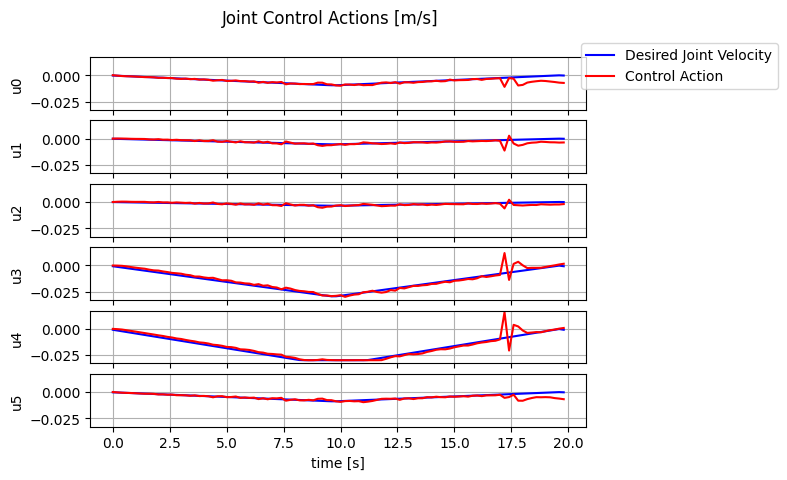

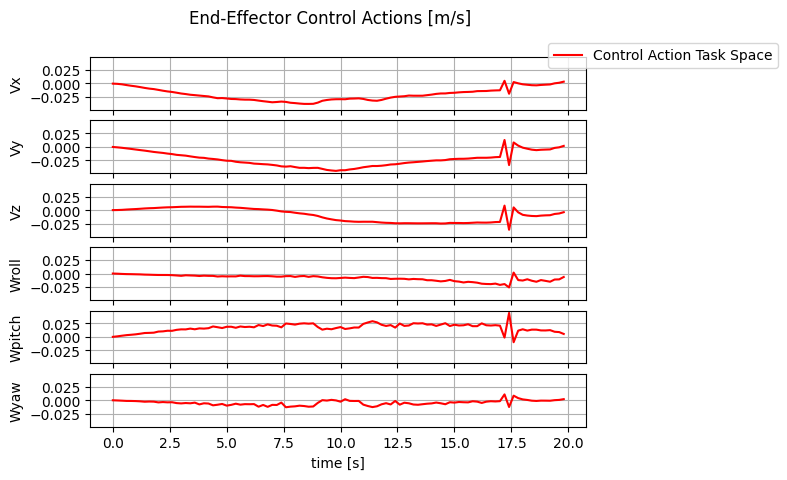

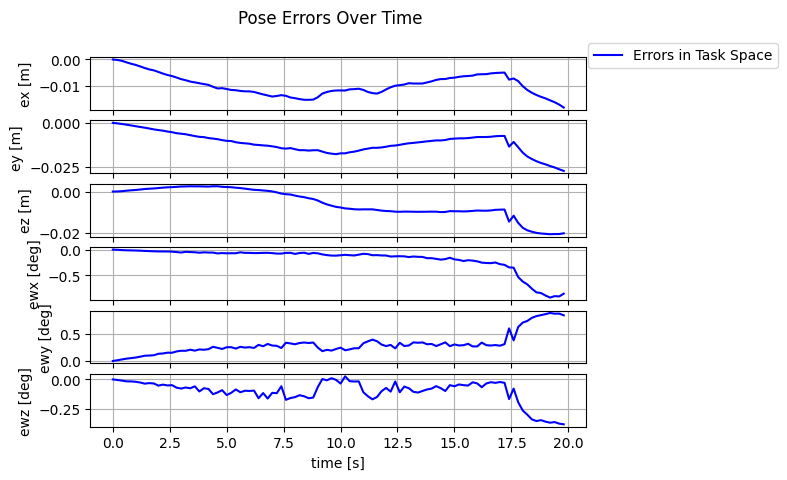

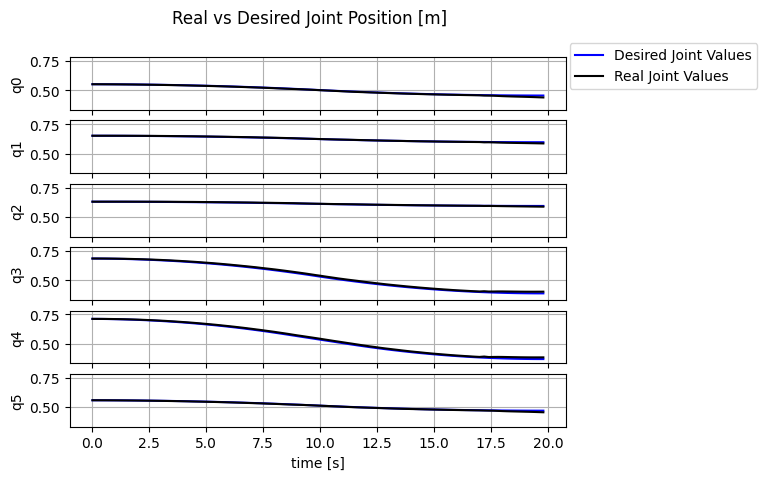

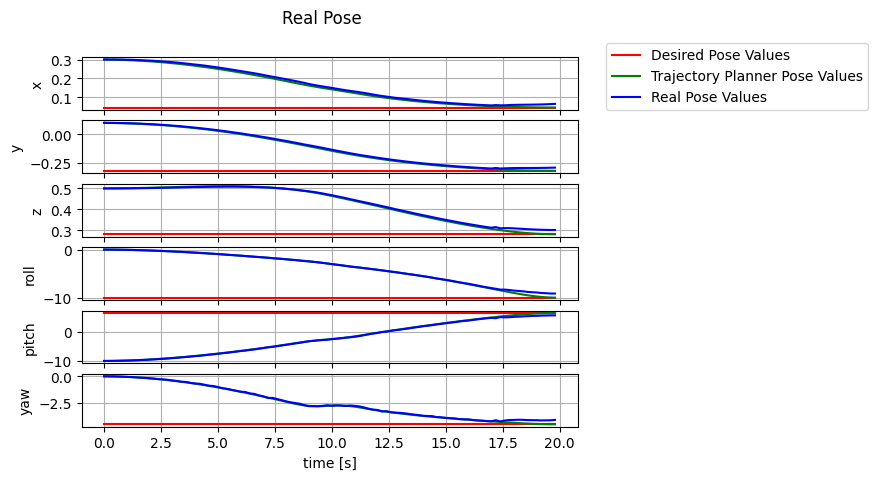

In [14]:
# Start Simulation
sim.start()

**Step 4 :**

Generate the video from the simulation.

 Note: this may take some time as the animation is generated with matplotlib. In each second, five frames are generated.

Elements:


*   In blue the Stewart Platform.
*   In black the closest singular configuration.
*   The static series of frames is the trajectory coming from the trapezoidal class.
*   The dynamic series of frames is the real trajectory of the robot.
*   In the top right corner is the table of the forces felt by the actuators under gravity (enumaration at the base of the platform).






In [15]:
 # Generate video
HTML(sim.anim.to_html5_video())